In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import iplot
import datetime as dt
import squarify
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score)

In [79]:
df = pd.read_csv("D:\فرادرس\My Studends\GHazaL\e-commerce-data.csv", encoding="ISO-8859-1")

In [80]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Variable Description

- InvoiceNo: Invoice number that consists 6 digits. If this code starts with letter 'c', it indicates a cancellation.
- StockCode: Product code that consists 5 digits.
- Description: Product name.
- Quantity: The quantities of each product per transaction.
- InvoiceDate: Represents the day and time when each transaction was generated.
- UnitPrice: Product price per unit.
- CustomerID: Customer number that consists 5 digits. Each customer has a unique customer ID.
- Country: Name of the country where each customer resides.

In [81]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [82]:
df.describe(include=['O'])

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


In [45]:
world_map = df[['CustomerID', 'InvoiceNo', 'Country']
              ].groupby(['CustomerID', 'InvoiceNo', 'Country']
                       ).count().reset_index(drop = False)
countries = world_map['Country'].value_counts()
data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names',
            z = countries,
            text = countries.index,
            colorbar = {'title':'Orders'},
            colorscale='Viridis',
            reversescale = False)

layout = dict(title={'text': "Number of Orders by Countries",
                     'y':0.9,
                     'x':0.5,
                     'xanchor': 'center',
                     'yanchor': 'top'},
              geo = dict(resolution = 50,
                         showocean = True,
                         oceancolor = "LightBlue",
                         showland = True,
                         landcolor = "whitesmoke",
                         showframe = True),
             template = 'plotly_white',
             height = 600,
             width = 1000)

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate = False)

In [83]:
def check_data(dataframe, head=5):
    print(" SHAPE ".center(70,'-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70,'-'))
    print(dataframe.dtypes)
    print(" MISSING VALUES ".center(70,'-'))
    print(dataframe.isnull().sum())
    print(" DUPLICATED VALUES ".center(70,'-'))
    print(dataframe.duplicated().sum())
    
check_data(df)

------------------------------- SHAPE --------------------------------
Rows: 541909
Columns: 8
------------------------------- TYPES --------------------------------
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object
--------------------------- MISSING VALUES ---------------------------
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
------------------------- DUPLICATED VALUES --------------------------
5268


In [84]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),
                'countries': len(df['Country'].value_counts())  
              }], columns = ['products', 'transactions', 'customers', 'countries'], index = ['quantity'])

,products,transactions,customers,countries
quantity,4070,25900,4372,38


In [85]:
# The number of products purchased in every transaction
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


In [86]:
# The number of transactions corresponding to canceled orders
products_per_basket['order_canceled'] = products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(products_per_basket[:5])

n1 = products_per_basket['order_canceled'].sum()
n2 = products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


In [87]:
display(df.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346.0,United Kingdom
286628,562032,21578,WOODLAND DESIGN COTTON TOTE BAG,6,8/2/2011 8:48,2.25,12347.0,Iceland
72263,542237,47559B,TEA TIME OVEN GLOVE,10,1/26/2011 14:30,1.25,12347.0,Iceland
72264,542237,21154,RED RETROSPOT OVEN GLOVE,10,1/26/2011 14:30,1.25,12347.0,Iceland


- InvoiceDate must be date not object.
- There are ouliters in Quantity and UnitPrice that have to be handled.
- There are negative values in UnitPrice and Quantity because of cancelled orders.
- Missing values in Customer ID and Description.
- Quantity and Unit Price should be multiplied in order to create Total Price.
- When an order is canceled, we have another transactions in the dataframe, mostly identical except for the Quantity and InvoiceDate variables. I decide to check if this is true for all the entries. To do this, I decide to locate the entries that indicate a negative quantity and check if there is systematically an order indicating the same quantity (but positive), with the same description (CustomerID, Description and UnitPrice)

## Data Preprocessing

In [88]:
# Change data type from object to datetime

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [89]:
# Missing Values
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

In [91]:
# Drop Duplicates
df.drop_duplicates(inplace = True)

In [92]:
# Cancelled Orders & Quantity
df = df[~df['InvoiceNo'].str.contains('C', na = False)]
df_ = df[df['Quantity'] > 0]

In [93]:
def his(col_name):
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=col_name, kde=True, fill=True)
    # plt.hist(df[col_name], bins=20, color='skyblue', edgecolor='black')  # Adjust bins as needed
    plt.title(f'{col_name} Distribution')
    plt.xlabel(f'{col_name}')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


def box(col_name):
  plt.figure(figsize=(8, 6))
  sns.boxplot(x=df[col_name], color='skyblue')
  plt.title(f'Box Plot of {col_name} Distribution')
  plt.xlabel(f'{col_name}')
  plt.grid(True)
  plt.show()

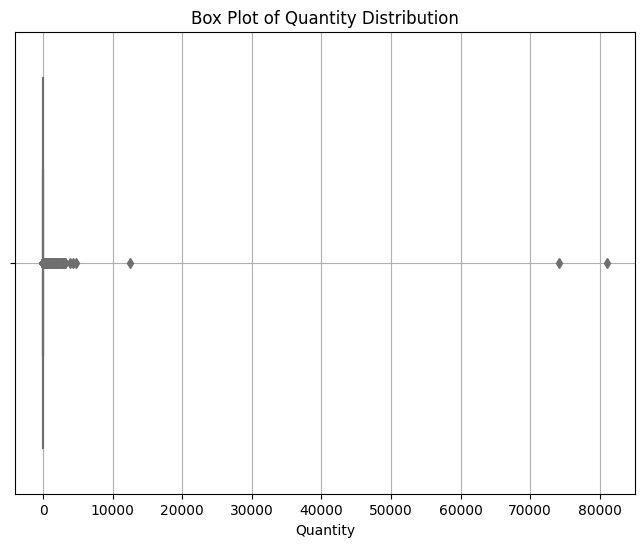

In [94]:
box('Quantity')

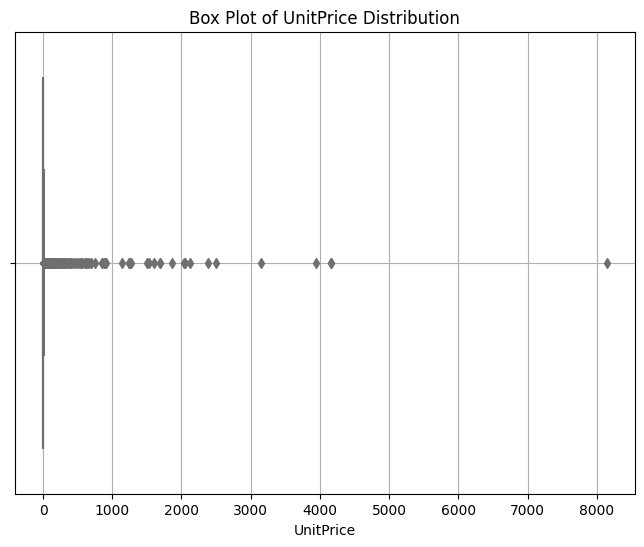

In [95]:
box('UnitPrice')

In [96]:
df[['Quantity', 'UnitPrice']].describe([0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99])

,Quantity,UnitPrice
count,392732.000000,392732.000000
mean,13.153718,3.125596
std,181.588420,22.240725
min,1.000000,0.000000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
85%,20.000000,4.950000
90%,24.000000,6.350000
95%,36.000000,8.500000


In [97]:
def replace_with_thresholds(dataframe, variable, q1 = 0.25, q3 = 0.75):
    
    '''
    Detects outliers with IQR method and replaces with thresholds 
    
    '''
    
    df_ = dataframe.copy()
    quartile1 = df_[variable].quantile(q1)
    quartile3 = df_[variable].quantile(q3)
    iqr = quartile3 - quartile1
    
    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr
    df_.loc[(df_[variable] < low_limit), variable] = low_limit
    df_.loc[(df_[variable] > up_limit), variable] = up_limit
    
    return df_


df = replace_with_thresholds(df, "Quantity", q1 = 0.01, q3 = 0.99)
df = replace_with_thresholds(df, "UnitPrice", q1 = 0.01, q3 = 0.99)

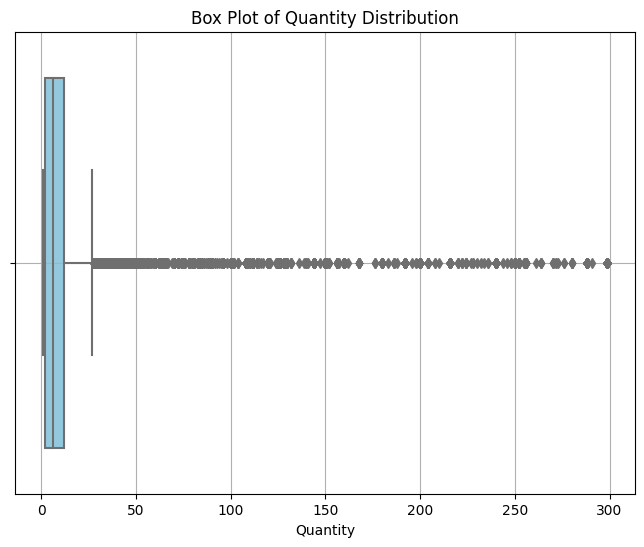

In [98]:
box('Quantity')

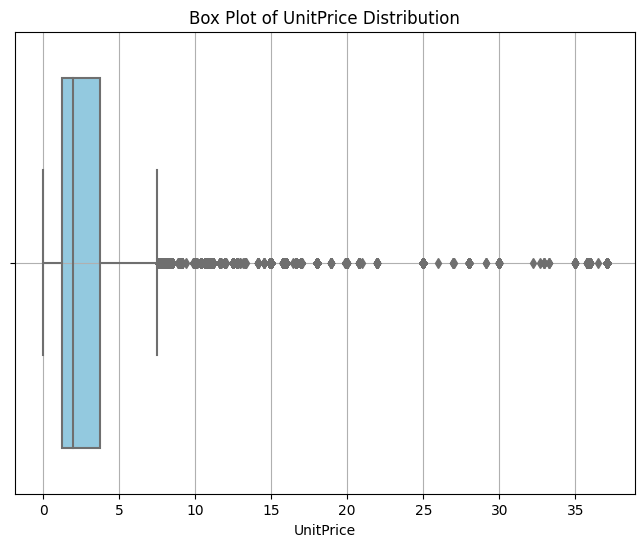

In [99]:
box('UnitPrice')

In [100]:
# Total Price
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

In [101]:
df.describe([0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99])

,Quantity,UnitPrice,CustomerID,TotalPrice
count,392732.000000,392732.000000,392732.000000,392732.000000
mean,11.953170,2.899636,15287.734822,20.839399
std,25.665488,3.237587,1713.567773,52.127192
min,1.000000,0.000000,12346.000000,0.000000
25%,2.000000,1.250000,13955.000000,4.950000
50%,6.000000,1.950000,15150.000000,12.390000
75%,12.000000,3.750000,16791.000000,19.800000
85%,20.000000,4.950000,17425.000000,25.920000
90%,24.000000,6.350000,17719.000000,35.400000
95%,36.000000,8.500000,17905.000000,67.500000


## RFM Analysis: Understanding Customer Behavior

RFM analysis is a powerful technique used in marketing and customer relationship management. It focuses on three key metrics:

- **Recency (R)**:
    - Recency refers to how recently a customer made a purchase.
    - The more recent the purchase, the more engaged the customer is with the brand.
    - Customers who have made recent purchases are more likely to respond positively to promotions and marketing efforts.
- **Frequency (F)**:
    - Frequency measures how often a customer makes purchases.
    - Customers who buy frequently are likely to be loyal and satisfied.
    - High-frequency customers contribute significantly to a company’s revenue.
- **Monetary Value (M)**:
    - Monetary value represents the amount of money a customer spends.
    - It helps differentiate heavy spenders from low-value purchasers.
    - Understanding the spending patterns of different customer segments is crucial for targeted marketing strategies.



### -----------------------------------------------------------------------------------------------

## Segmentation

The primary purpose of **RFM scores** is to segment customers based on their behavior and interactions with the business. By analyzing **recency**, **frequency**, and **monetary value**, companies can group customers into meaningful segments. These segments help tailor marketing strategies, personalize communication, and optimize resource allocation.

## Customer Insights

RFM scores provide insights into customer behavior:

- **Recency (R)**: How recently a customer made a purchase.
- **Frequency (F)**: How often a customer interacts with the brand.
- **Monetary Value (M)**: The amount of money a customer spends.

Understanding these dimensions helps identify loyal customers, high spenders, and potential churn risks.

## Retention and Loyalty

Recency plays a crucial role in customer retention:

- Recent customers are more likely to engage and continue their relationship with the brand.
- Targeted retention efforts can be directed toward customers who haven’t interacted recently.
- Loyalty programs can be tailored based on RFM segments to reward and retain valuable customers.

## Targeted Marketing

RFM scores guide targeted marketing campaigns:

- High RFM score segments (e.g., recent, frequent, high spenders) receive personalized promotions.
- Low RFM score segments (e.g., inactive or low spenders) may receive re-engagement offers.
- Customized messaging improves conversion rates and customer satisfaction.

## Lifetime Value Prediction

RFM scores contribute to predicting **customer lifetime value (CLV)**:

- High RFM scores correlate with higher CLV.
- Businesses can allocate resources effectively by focusing on high-value segments.

## Product Recommendations

RFM-based recommendations:

- Suggest products or services based on a customer’s behavior.
- For example, recommend complementary items to frequent buyers.

### -----------------------------------------------------------------------------------------------

## RFM Score Calculation Steps in Python

### Data Preparation

1. **Data Collection and Cleaning**:
   - Gather relevant data sources (e.g., sales transactions, customer profiles).
   - Clean the data by handling missing values, removing duplicates, and ensuring consistency.

2. **Data Features**:
   - You'll need the following features:
     - **Recency**: Last purchase date (measured in days since the last interaction).
     - **Frequency**: Number of purchases within a specific time period (e.g., one year).
     - **Monetary Value**: Total sales from each customer.

### Calculate RFM Scores

3. **Scoring Methodology**:
   - Determine the scoring scale (usually from 1 to 5) for each RFM metric:
     - **Recency**: Higher scores for more recent interactions (e.g., 5 for the most recent, 1 for the least recent).
     - **Frequency**: Higher scores for more frequent interactions (e.g., 5 for high frequency, 1 for low frequency).
     - **Monetary Value**: Higher scores for higher spending (e.g., 5 for high monetary value, 1 for low value).

4. **Individual Scores**:
   - Calculate individual scores for each customer based on their recency, frequency, and monetary values.
   - For example:
     - If a customer made a recent purchase (Recency = 10 days), assign a high recency score (e.g., 5).
     - If a customer made frequent purchases (Frequency = 10 times), assign a high frequency score (e.g., 5).
     - If a customer spent a significant amount (Monetary = $1000), assign a high monetary score (e.g., 5).

### Segmentation

5. **Combine Scores**:
   - Create the overall RFM score for each customer by combining the individual scores.
   - For example, if a customer has Recency = 5, Frequency = 4, and Monetary = 3, the RFM score could be 543.

6. **Sorting Customers**:
   - Sort customers based on their RFM scores.
   - Higher RFM scores indicate more valuable and engaged customers.

### Identify Customer Segments

7. **Segmentation Groups**:
   - Use the RFM scores to segment customers into groups:
     - **High RFM Score**: Valuable and engaged customers (e.g., RFM score >= 10).
     - **Low RFM Score**: Less engaged or less valuable customers (e.g., RFM score < 10).

8. **Tailor Marketing Strategies**:
   - Customize marketing efforts based on these segments.
   - Reward loyal customers (high RFM) and re-engage low-value customers (low RFM).

### -----------------------------------------------------------------------------------------------

In [102]:
print(df['InvoiceDate'].max())

2011-12-09 12:50:00


In [103]:
today_date = dt.datetime(2011,12,11)

rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (today_date - x.max()).days,
                                    'InvoiceNo': lambda x: x.nunique(),
                                    'TotalPrice': lambda x: x.sum()})

rfm.columns = ['recency', 'frequency', 'monetary']
rfm = rfm.reset_index()

rfm.head()

,CustomerID,recency,frequency,monetary
0,12346.0,326,1,310.44
1,12347.0,3,7,4310.00
2,12348.0,76,4,1770.78
3,12349.0,19,1,1491.72
4,12350.0,311,1,331.46


# Segmentation

## Strategy 1

In [104]:
def rfm_scores(dataframe) -> pd.core.frame.DataFrame:

    df_ = dataframe.copy()

    # Calculate RFM scores
    df_['RecencyScore'] = pd.qcut(df_['recency'], q=5, labels=[5, 4, 3, 2, 1])
    df_['FrequencyScore'] = pd.qcut(df_['frequency'].rank(method="first"), q=5, labels=[1, 2, 3, 4, 5])
    df_['MonetaryScore'] = pd.qcut(df_['monetary'], q=5, labels=[1, 2, 3, 4, 5])

    # Combine RFM scores
    df_['RFM_Score'] = df_['RecencyScore'].astype(int) + df_['FrequencyScore'].astype(int) + df_['MonetaryScore'].astype(int)

    return df_


rfm = rfm_scores(rfm)

In [105]:
rfm.head()

,CustomerID,recency,frequency,monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score
0,12346.0,326,1,310.44,5,1,2,8
1,12347.0,3,7,4310.00,1,5,5,11
2,12348.0,76,4,1770.78,4,4,4,12
3,12349.0,19,1,1491.72,2,1,4,7
4,12350.0,311,1,331.46,5,1,2,8


In [106]:
# Identify potential customer segments
high_value_customers = rfm[rfm['RFM_Score'] >= 10]
low_value_customers = rfm[rfm['RFM_Score'] < 10]

In [107]:
print("High-Value Customers:")
high_value_customers


High-Value Customers:


,CustomerID,recency,frequency,monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score
1,12347.0,3,7,4310.00,1,5,5,11
2,12348.0,76,4,1770.78,4,4,4,12
5,12352.0,37,8,1756.34,3,5,4,12
7,12354.0,233,1,1079.40,5,1,4,10
9,12356.0,23,3,2811.43,2,3,5,10
...,...,...,...,...,...,...,...,...
4323,18263.0,26,3,1213.16,2,4,4,10
4324,18265.0,73,2,801.51,4,3,3,10
4328,18272.0,3,6,3078.58,1,5,5,11
4337,18283.0,4,16,2045.53,1,5,5,11


In [108]:
print("\nLow-Value Customers:")
low_value_customers


Low-Value Customers:


,CustomerID,recency,frequency,monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score
0,12346.0,326,1,310.44,5,1,2,8
3,12349.0,19,1,1491.72,2,1,4,7
4,12350.0,311,1,331.46,5,1,2,8
6,12353.0,205,1,89.00,5,1,1,7
8,12355.0,215,1,459.40,5,1,2,8
...,...,...,...,...,...,...,...,...
4332,18277.0,59,1,110.38,3,2,1,6
4333,18278.0,74,1,173.90,4,2,1,7
4334,18280.0,278,1,180.60,5,2,1,8
4335,18281.0,181,1,80.82,5,2,1,8


## Strategy 2

In [109]:
def rfm_scores_2(dataframe) -> pd.core.frame.DataFrame:

    df_ = dataframe.copy()
    df_["recency_score"] = pd.qcut(df_["recency"], 5, labels=[5, 4, 3, 2, 1])
    df_["frequency_score"] = pd.qcut(df_["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
    df_["monetary_score"] = pd.qcut(df_["monetary"], 5, labels=[1, 2, 3, 4, 5])
    df_["RFM_Score_2"] = df_["recency_score"].astype(str) + df_["frequency_score"].astype(str)

    return df_


rfm = rfm_scores_2(rfm)

In [110]:
rfm.head()

,CustomerID,recency,frequency,monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,recency_score,frequency_score,monetary_score,RFM_Score_2
0,12346.0,326,1,310.44,5,1,2,8,1,1,2,11
1,12347.0,3,7,4310.00,1,5,5,11,5,5,5,55
2,12348.0,76,4,1770.78,4,4,4,12,2,4,4,24
3,12349.0,19,1,1491.72,2,1,4,7,4,1,4,41
4,12350.0,311,1,331.46,5,1,2,8,1,1,2,11


In [111]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_Score_2'].replace(seg_map, regex = True)

rfm.head()

,CustomerID,recency,frequency,monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,recency_score,frequency_score,monetary_score,RFM_Score_2,segment
0,12346.0,326,1,310.44,5,1,2,8,1,1,2,11,hibernating
1,12347.0,3,7,4310.00,1,5,5,11,5,5,5,55,champions
2,12348.0,76,4,1770.78,4,4,4,12,2,4,4,24,at_Risk
3,12349.0,19,1,1491.72,2,1,4,7,4,1,4,41,promising
4,12350.0,311,1,331.46,5,1,2,8,1,1,2,11,hibernating


- **Hibernating**: Customers who have low recency and frequency scores (e.g., `[1-2][1-2]`).
- **At Risk**: Customers with moderate recency and frequency scores (e.g., `[1-2][3-4]`).
- **Can’t Lose**: Customers with low recency but high monetary value (e.g., `[1-2]5`).
- **About to Sleep**: Customers with moderate recency (e.g., `3[1-2]`).
- **Need Attention**: Customers with low recency and moderate frequency (e.g., `33`).
- **Loyal Customers**: Customers with moderate to high recency and frequency (e.g., `[3-4][4-5]`).
- **Promising**: Customers with moderate recency and high monetary value (e.g., `41`).
- **New Customers**: Recently acquired customers (e.g., `51`).
- **Potential Loyalists**: Customers with moderate to high frequency and moderate monetary value (e.g., `[4-5][2-3]`).
- **Champions**: High-value, engaged customers (e.g., `5[4-5]`).

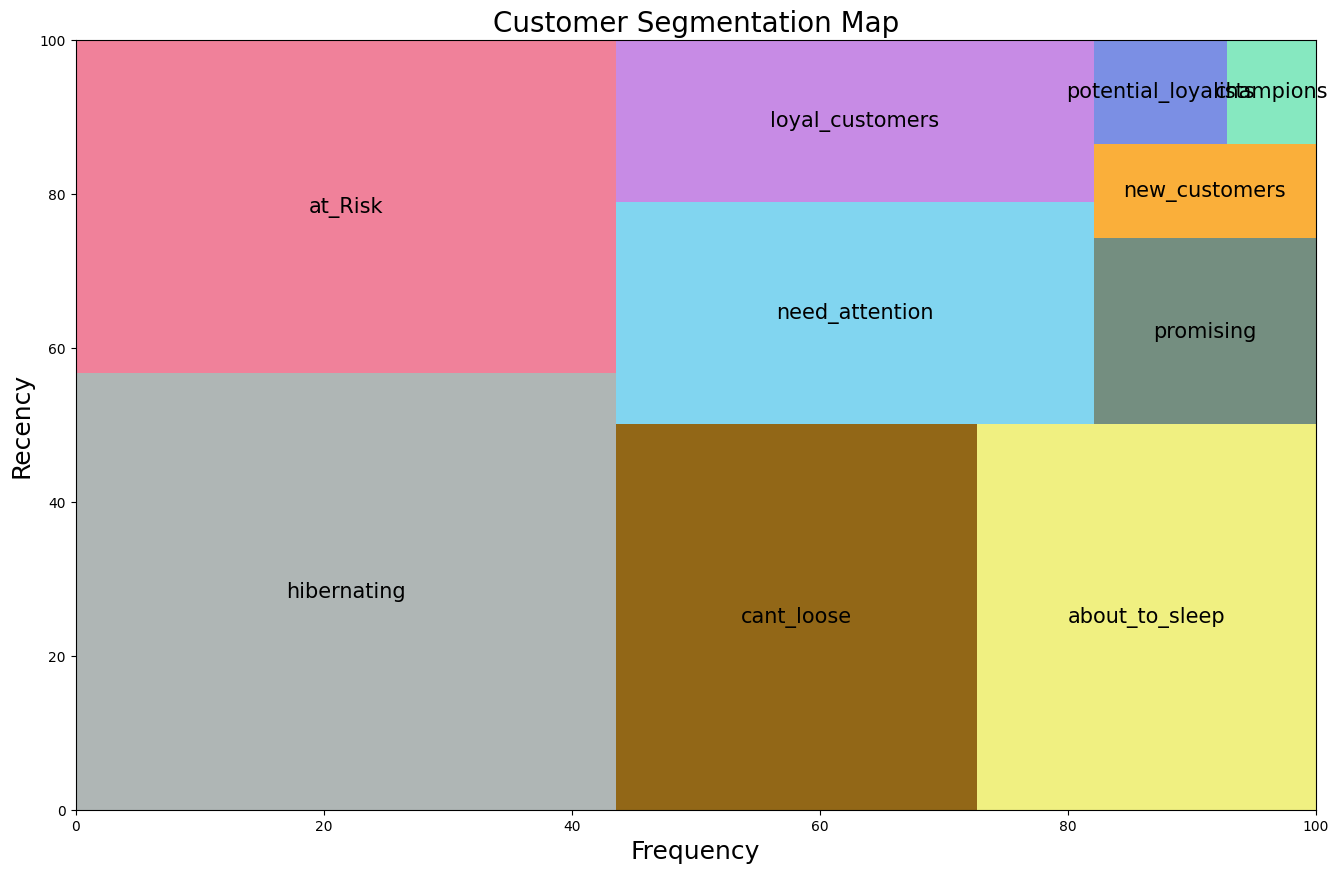

In [112]:
segments = rfm["segment"].value_counts().sort_values(ascending=False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
squarify.plot(
            sizes=segments,
            label=[label for label in seg_map.values()],
            color=[
                "#AFB6B5",
                "#F0819A",
                "#926717",
                "#F0F081",
                "#81D5F0",
                "#C78BE5",
                "#748E80",
                "#FAAF3A",
                "#7B8FE4",
                "#86E8C0",],
            pad=False,
            bar_kwargs={"alpha": 1},
            text_kwargs={"fontsize": 15},
)
plt.title("Customer Segmentation Map", fontsize=20)
plt.xlabel("Frequency", fontsize=18)
plt.ylabel("Recency", fontsize=18)
plt.show()

## Model Evaluation



In [113]:
print(' RFM Model Evaluation '.center(70, '='))
X = rfm[['recency_score', 'frequency_score']]
labels = rfm['segment']
print(f'Number of Observations: {X.shape[0]}')
print(f'Number of Segments: {labels.nunique()}')
print(f'Silhouette Score: {round(silhouette_score(X, labels), 3)}')
print(f'Calinski Harabasz Score: {round(calinski_harabasz_score(X, labels), 3)}')
print(f'Davies Bouldin Score: {round(davies_bouldin_score(X, labels), 3)} \n{70*"="}')

======================== RFM Model Evaluation ========================
Number of Observations: 4339
Number of Segments: 10
Silhouette Score: 0.471
Calinski Harabasz Score: 4591.503
Davies Bouldin Score: 0.633 


## Segment Analysis

In [114]:
rfm[['recency','monetary','frequency','segment']].groupby('segment').agg({'mean','std','max','min'})

recency                             monetary               \
                        min        mean        std  max      min         mean   
segment                                                                         
about_to_sleep           34   53.312500  10.943474   72     6.20   466.957159   
at_Risk                  73  153.785835  68.618828  374    52.00   934.843417   
cant_loose               73  132.968254  65.250378  373    70.02  2640.768095   
champions                 1    6.361769   3.683300   13   198.23  6483.838017   
hibernating              73  217.605042  92.013560  374     3.75   397.558639   
loyal_customers          15   33.608059  15.577050   72    36.56  2744.332498   
need_attention           34   52.427807  11.552074   72     6.90   842.535160   
new_customers             1    7.428571   3.902112   13    89.94   311.693214   
potential_loyalists       1   17.398760   9.338808   33    20.80   669.889452   
promising                15   23.421053   5.238115   33     0.00   280.680000   

                                              frequency                        \
                              std         max       min       mean        std   
segment                                                                         
about_to_sleep         533.107076    6207.670         1   1.161932   0.368913   
at_Risk                940.598240   11072.670         2   2.878583   0.954415   
cant_loose            2009.591192   10254.180         6   8.380952   4.289630   
champions            18358.902073  266163.525         3  12.417062  16.476484   
hibernating            553.599170    9182.345         1   1.101774   0.302492   
loyal_customers       5402.259178  120210.355         3   6.479853   4.545669   
need_attention         728.557628    4353.830         2   2.326203   0.470081   
new_customers          173.838038     848.550         1   1.000000   0.000000   
potential_loyalists    598.936709    4628.750         1   2.010331   0.651401   
promising              222.068296    1491.720         1   1.000000   0.000000   

                          
                     max  
segment                   
about_to_sleep         2  
at_Risk                6  
cant_loose            34  
champions            210  
hibernating            2  
loyal_customers       63  
need_attention         3  
new_customers          1  
potential_loyalists    3  
promising              1

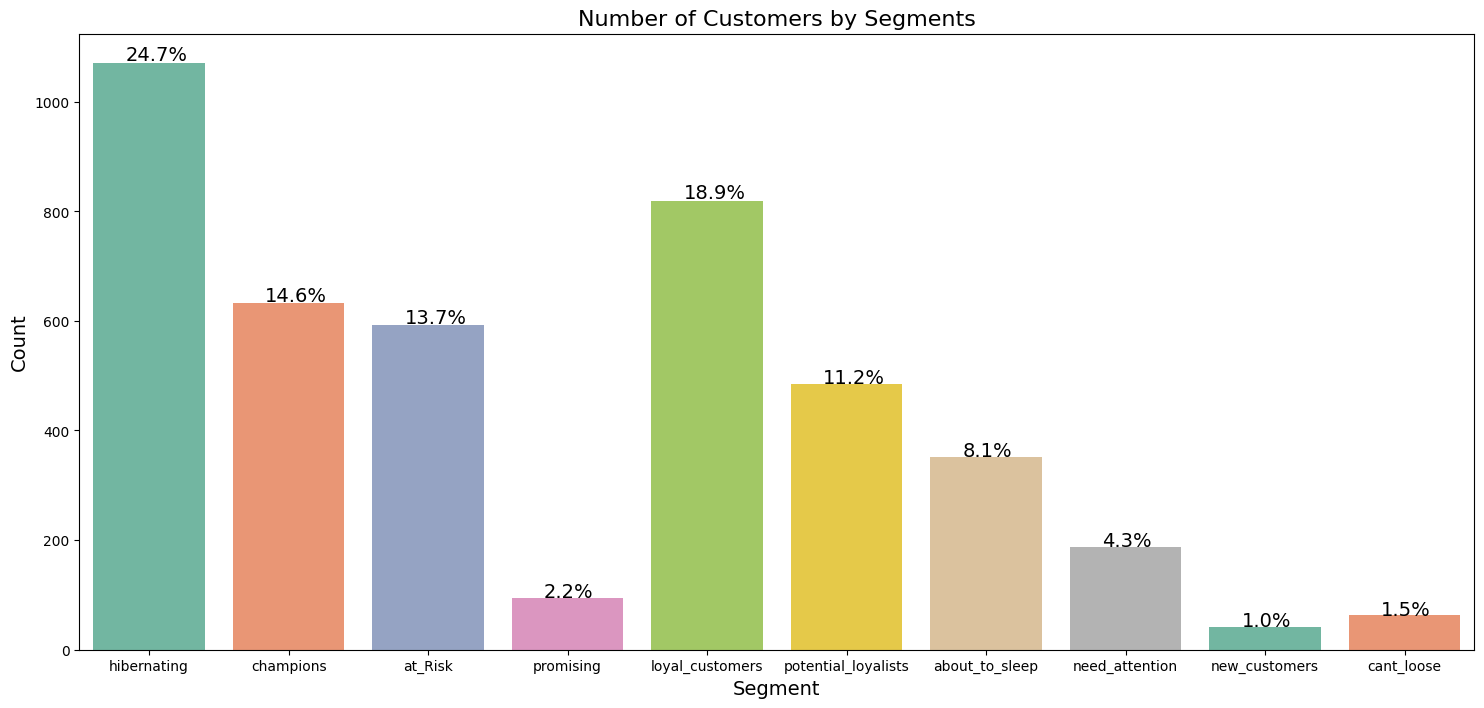

In [115]:
plt.figure(figsize = (18, 8))
ax = sns.countplot(data = rfm,
                   x = 'segment',
                   palette = 'Set2')
total = len(rfm.segment)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 14)
plt.title('Number of Customers by Segments', size = 16)
plt.xlabel('Segment', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.show()

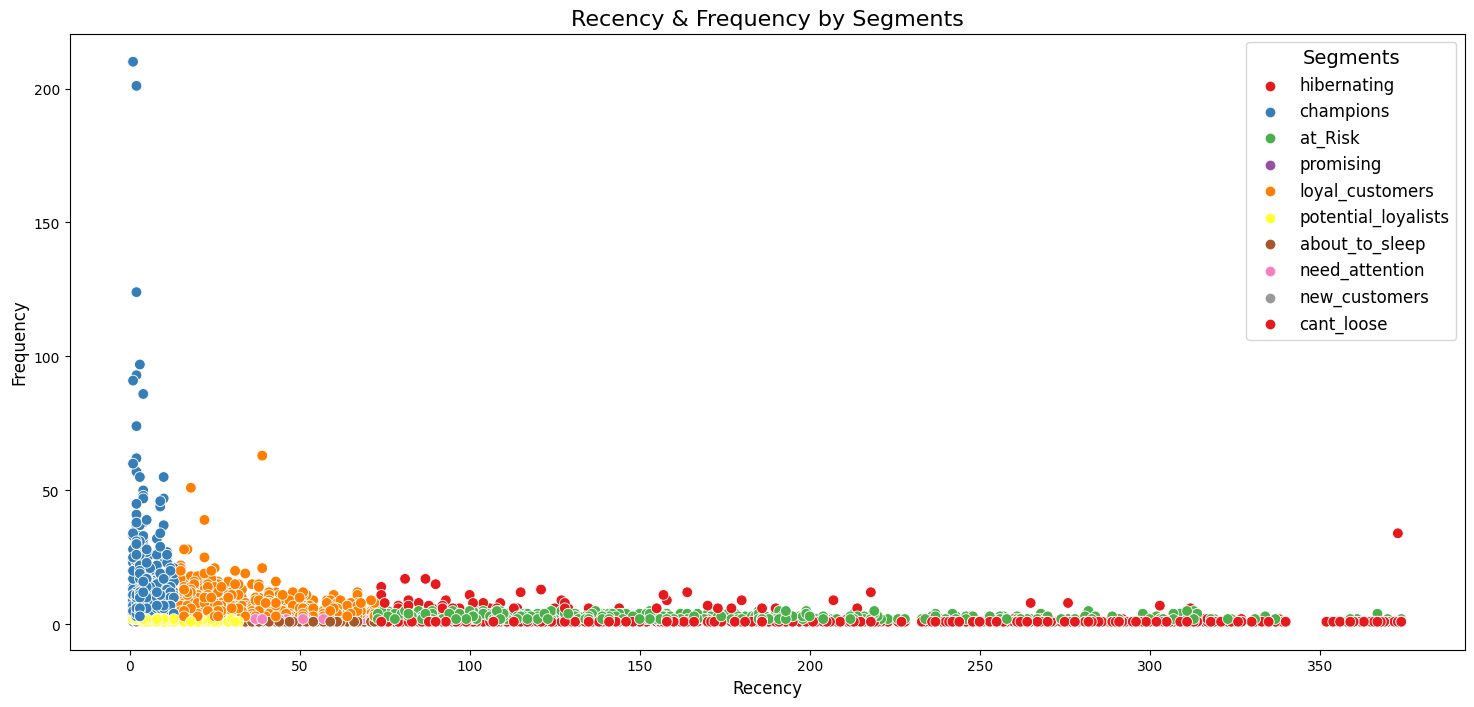

In [116]:
plt.figure(figsize=(18, 8))
sns.scatterplot(
    data=rfm, x="recency", y="frequency", hue="segment", palette='Set1', s=60)

plt.title("Recency & Frequency by Segments", size=16)
plt.xlabel("Recency", size=12)
plt.ylabel("Frequency", size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc="best", fontsize=12, title="Segments", title_fontsize=14)
plt.show()